# OCO-2 L2 Data Exploration


In [10]:
%load_ext autoreload
%autoreload 2
from utils.location import get_location
from data.load import read_remote_co2

lon, lat = get_location()

loc_range = 8

lat_min = lat - loc_range
lat_max = lat + loc_range
lon_min = lon - loc_range
lon_max = lon + loc_range

co2_df = read_remote_co2(2024, lat_min, lat_max, lon_min, lon_max)
co2_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


QUEUEING TASKS | :   0%|          | 0/25 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/25 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/25 [00:00<?, ?it/s]

,sounding_id,xco2,time,lat,lon
0,2.024011e+15,424.378326,2024-01-09 11:34:20.363008000,51.234432,19.315004
1,2.024011e+15,418.453705,2024-01-09 11:37:32.309019904,51.390057,19.307419
2,2.024013e+15,423.817993,2024-01-28 12:03:51.336021504,44.306427,15.055919
3,2.024013e+15,424.835846,2024-01-28 12:03:51.363017728,44.300079,15.066711
4,2.024013e+15,424.435852,2024-01-28 12:03:53.723013120,44.432381,15.027963
...,...,...,...,...,...
6741,2.024123e+15,424.288177,2024-12-29 12:05:31.309005824,49.442947,13.013187
6742,2.024123e+15,424.713837,2024-12-29 12:05:31.336002048,49.436729,13.025175
6743,2.024123e+15,425.714783,2024-12-29 12:05:31.362998528,49.430428,13.037101
6744,2.024123e+15,425.458405,2024-12-29 12:05:31.388988928,49.424061,13.048923


In [11]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

df = co2_df
save: bool = False
n_clusters: int = 250 if 250 < len(df) else len(df)
coords = df[['lat', 'lon']]
kmeans = KMeans(n_clusters=n_clusters, random_state=42, max_iter=105)
df['cluster'] = kmeans.fit_predict(coords)

df['cluster']

0        66
1        66
2       181
3       181
4       181
       ... 
6741     28
6742     28
6743     28
6744    191
6745     28
Name: cluster, Length: 6746, dtype: int32

In [35]:
merged = df.groupby(['cluster'], as_index=False).agg({
    'lat': 'mean',
    'lon': 'mean',
    'xco2': 'max',
})
merged[['lat', 'lon']] = merged[['lat', 'lon']].astype(float).round(2)

merged

,cluster,lat,lon,xco2
0,0,46.49,24.29,419.508698
1,1,58.57,17.45,417.990326
2,2,48.35,18.21,424.353851
3,3,48.41,13.51,424.987305
4,4,44.99,21.15,425.135101
...,...,...,...,...
245,245,50.69,22.29,420.383148
246,246,49.56,13.04,425.275513
247,247,58.64,17.38,417.776276
248,248,56.34,19.01,418.609222


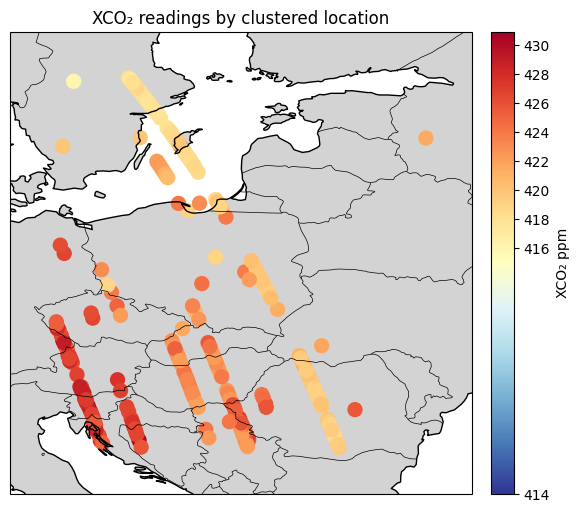

In [62]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

baseline = 415
min = merged['xco2'].min() if merged['xco2'].min() < baseline else baseline - 1
norm = mcolors.TwoSlopeNorm(
    vmin=min, 
    vcenter=baseline, 
    vmax=merged['xco2'].max()
)

fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([
    merged['lon'].min() - 2, merged['lon'].max() + 2,
    merged['lat'].min() - 2, merged['lat'].max() + 2
], crs=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

sc = ax.scatter(
    merged['lon'], 
    merged['lat'], 
    c=merged['xco2'], 
    s=100,
    cmap='RdYlBu_r', 
    norm=norm,
    transform=ccrs.PlateCarree()
)

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02, label='XCO₂ ppm')

plt.title('XCO₂ readings by clustered location')

plt.show()

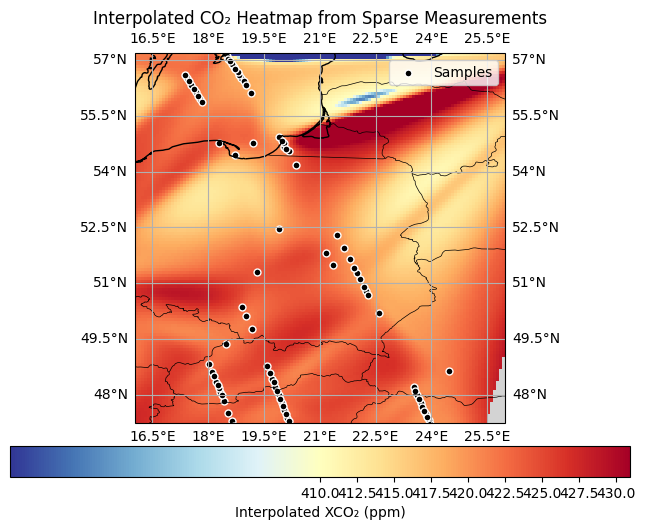

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
baseline = 410
min = merged['xco2'].min() if merged['xco2'].min() < baseline else baseline - 1
norm = mcolors.TwoSlopeNorm(
    vmin=min, 
    vcenter=baseline, 
    vmax=merged['xco2'].max()
)
points = np.column_stack((merged['lon'], merged['lat']))
values = merged['xco2']

lon_grid = np.linspace(merged['lon'].min(), merged['lon'].max(), 200)
lat_grid = np.linspace(merged['lat'].min(), merged['lat'].max(), 200)
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

grid_xco2 = griddata(points, values, (lon_mesh, lat_mesh), method='cubic')
grid_xco2 = gaussian_filter(grid_xco2, sigma=2)

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.set_extent([
    merged['lon'].min() + 3,
    merged['lon'].max() - 3,
    merged['lat'].min() + 3,
    merged['lat'].max() - 3
])
ax.gridlines(draw_labels=True)

img = ax.pcolormesh(
    lon_mesh, lat_mesh, grid_xco2,
    cmap='RdYlBu_r', shading='auto', norm=norm
)
plt.colorbar(img, label='Interpolated XCO₂ (ppm)', orientation='horizontal', pad=0.05)

ax.scatter(merged['lon'], merged['lat'], c='k', s=25, label='Samples', edgecolors='white')
plt.legend()
plt.title('Interpolated CO₂ Heatmap from Sparse Measurements')
plt.show()

In [46]:
top_clean_spots = merged.sort_values('xco2', inplace=False, ascending=True)
top_clean_spots = top_clean_spots[top_clean_spots['xco2'] < 419]
top_clean_spots

,cluster,lat,lon,xco2
47,47,60.04,13.78,416.072601
136,136,60.06,16.25,417.137848
25,25,59.26,16.90,417.238495
200,200,60.13,16.20,417.545898
247,247,58.64,17.38,417.776276
209,209,59.18,16.96,417.780426
148,148,59.09,17.04,417.885040
156,156,59.84,16.44,417.892670
80,80,59.68,16.57,417.973328
1,1,58.57,17.45,417.990326


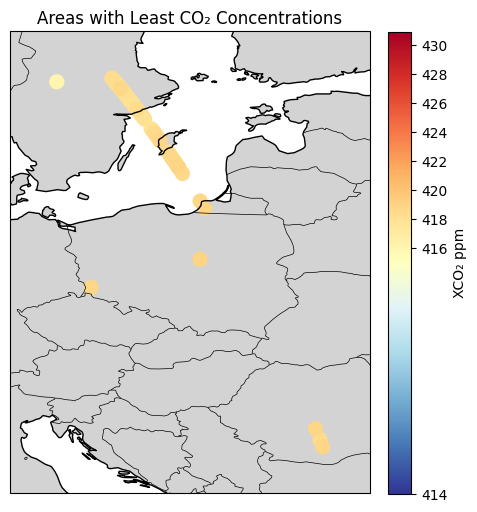

In [54]:
baseline = 415
min = top_clean_spots['xco2'].min() if top_clean_spots['xco2'].min() < baseline else baseline - 1
norm = mcolors.TwoSlopeNorm(
    vmin=min, 
    vcenter=baseline, 
    vmax=merged['xco2'].max()
)

fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([
    top_clean_spots['lon'].min() - 2, top_clean_spots['lon'].max() + 2,
    top_clean_spots['lat'].min() - 2, top_clean_spots['lat'].max() + 2
], crs=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

sc = ax.scatter(
    top_clean_spots['lon'], 
    top_clean_spots['lat'], 
    c=top_clean_spots['xco2'], 
    s=100,
    cmap='RdYlBu_r', 
    norm=norm,
    transform=ccrs.PlateCarree()
)

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02, label='XCO₂ ppm')

plt.title('Areas with Least CO₂ Concentrations')

plt.show()

In [59]:
top_polluted_spots = merged.sort_values('xco2', inplace=False, ascending=False)
top_polluted_spots = top_polluted_spots[top_polluted_spots['xco2'] > 427]
top_polluted_spots

,cluster,lat,lon,xco2
18,18,48.86,13.31,430.917023
56,56,44.55,16.60,430.302887
74,74,46.03,14.41,429.405029
140,140,46.58,14.22,429.087494
229,229,48.75,13.36,429.026642
202,202,46.86,14.05,428.827881
221,221,46.73,14.10,428.777893
154,154,46.69,14.16,428.432526
23,23,45.14,16.38,428.381439
125,125,44.99,14.74,428.368286


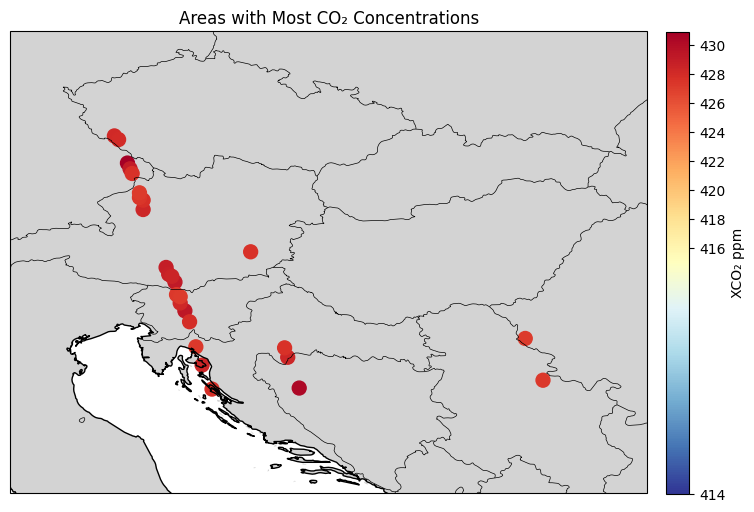

In [60]:
baseline = 415
min = top_polluted_spots['xco2'].min() if top_polluted_spots['xco2'].min() < baseline else baseline - 1
norm = mcolors.TwoSlopeNorm(
    vmin=min, 
    vcenter=baseline, 
    vmax=merged['xco2'].max()
)

fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([
    top_polluted_spots['lon'].min() - 2, top_polluted_spots['lon'].max() + 2,
    top_polluted_spots['lat'].min() - 2, top_polluted_spots['lat'].max() + 2
], crs=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

sc = ax.scatter(
    top_polluted_spots['lon'], 
    top_polluted_spots['lat'], 
    c=top_polluted_spots['xco2'], 
    s=100,
    cmap='RdYlBu_r', 
    norm=norm,
    transform=ccrs.PlateCarree()
)

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02, label='XCO₂ ppm')

plt.title('Areas with Most CO₂ Concentrations')

plt.show()